# Arabic SA with LSTM and LLMs

===============================================
Focus:

1. LSTM with LLMs embedding

2. Fine-tuning LLM for Arabic SA and evaluation (with Arabic tweets data).


## Part (1) LSTM with LLM embeddings for Arabic SA


In [1]:
! git clone  https://github.com/waheebedrees/NLP_lab.git

%cd  NLP_lab/



Cloning into 'NLP_lab'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 0), reused 5 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (5/5), 967.81 KiB | 3.02 MiB/s, done.
/content/NLP_lab


In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import random


def seed(seed: int = 42):
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# This is a version of BERT model trained for Arabic SA
MODEL_NAME = "CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment"

train_data = pd.read_excel("AraSenti_all.xlsx")

test_data = pd.read_excel("HIAQatar_tweets.xlsx")

train_data.head(), test_data.head()


(                                               tweet  label
 0  اغلاق_المحلات_9_مساءمو كافي تقفل كل شوي عشان ا...      0
 1  إغلاق_المحلات_9_مساء لكل قرار سلبيات وإيجابيات...      0
 2  اغلاق_المحلات_9_مساء المولات بالذات قد تكون ال...      0
 3  اغلاق_المحلات_9_مساء طيب متى يفتح المحل السادس...      0
 4  اغلاق_المحلات_9_مساء وبما أن الجو اليوم حلو با...      0,
    ano3  ano2  ano1  agree text_label  label  \
 0     1     1     1      1   positive      1   
 1     1     1     1      1   positive      1   
 2     1     1     1      1   positive      1   
 3     0     0     0      1   negative      0   
 4     0     0     0      1   negative      0   
 
                                                tweet  
 0  @ @ @ مطار حمد الدولي ينضم لنادي الخمس نجوم، م...  
 1  @ بيض الله وجه إدارة المطار على حسن الاستقبال ...  
 2  @ مبادرة مميزة وغير مستغربه من إدارة مطار حمد ...  
 3  @ نرجو من إدارة مطار حمد عمل خطة بديلة لأحتكار...  
 4  @ نرجو من إدارة مطار حمد عمل خطة بديلة لأحتكار...  )

In [3]:
display(train_data.describe(), train_data.info(), train_data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15751 entries, 0 to 15750
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   15751 non-null  object
 1   label   15751 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 246.2+ KB


,label
count,15751.000000
mean,0.903752
std,0.822234
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


None

,0
tweet,0
label,0


In [4]:
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)


In [5]:
train_data.iloc[0]


,0
tweet,اغلاق_المحلات_9_مساءمو كافي تقفل كل شوي عشان ا...
label,0


In [6]:
train_data.label.value_counts()


,count
label,
0,6155
1,4957
2,4639


In [7]:
# this will use it later for inverse mapping

inverse_mapping = {0: "negative", 1: "neutral", 2: "positive"}


def mapping(
    x): return "negative" if x == 0 else "neutral" if x == 1 else "positive" if x == 2 else -1


In [8]:
import re
# Data preprocessing function
# In this function you should clean the Arabic text and normlize it
# remove repeated letter, english letter, punctuation, etc.
# Input: unclean tweet
# Output: clean tweet


def clean_tweet(tweet: str) -> str:
    '''
    write your code here
    '''
    tweet = str(tweet)

    # remove english letters
    tweet = re.sub(r'[a-zA-Z0-9]+', '', tweet, flags=re.MULTILINE)

    # remove emoijis
    tweet = re.sub(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
        "]+",
        "",
        tweet
    )

    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|pic\.twitter\S+', '', tweet)

    # remove mentions
    tweet = re.sub(r'@\w+', '', tweet)
    # remove hashtags
    tweet = re.sub(r'#\w+', '', tweet)
    # Remove digits
    tweet = re.sub(r'\d+', '', tweet)

    # Remove extra symbols and punctuation
    # This keeps only letters, numbers, and spaces
    tweet = re.sub(r'[^\w\s]', '', tweet)

    # Remove repeated letters
    # https://stackoverflow.com/questions/39137851/how-to-deal-with-repeated-letters-in-arabic
    tweet = re.sub(r'(.)\1+', r'\1', tweet)

    # Replace underscores and hyphens with spaces
    tweet = re.sub(r'[_\-]', ' ', tweet)

    # Keep only Arabic letters and spaces
    tweet = re.sub(r'[^\u0600-\u06FF\s]', '', tweet)

    # Remove HTML entities
    tweet = re.sub(r'&[a-z]+;', '', tweet)
    # Remove extra whitespaces

    tweet = normalize_arabic(tweet)

    tweet = re.sub(r'\s+', ' ', tweet).strip()
    return tweet


def normalize_arabic(text):
    # Normalize different forms of Alef
    text = re.sub(r'[إأآا]', 'ا', text)
    # Normalize Yeh
    text = re.sub(r'[يى]', 'ي', text)
    # Normalize Teh Marbuta
    text = re.sub(r'ة', 'ه', text)
    # Normalize Hamza
    text = re.sub(r'ؤ', 'و', text)
    text = re.sub(r'ئ', 'ي', text)
    return text


# Test the function
text = "هذتيتيتا مثال على تنظيف التغريدات!!! Visit https://example.com #مثال @user"
cleaned_text = clean_tweet(text)
print(cleaned_text)


train_data['cleaned_text'] = train_data['tweet'].apply(clean_tweet)
test_data['cleaned_text'] = test_data['tweet'].apply(clean_tweet)
train_data.head()


هذتيتيتا مثال علي تنظيف التغريدات


,tweet,label,cleaned_text
0,اغلاق_المحلات_9_مساءمو كافي تقفل كل شوي عشان ا...,0,اغلاق المحلات مساءمو كافي تقفل كل شوي عشان الص...
1,إغلاق_المحلات_9_مساء لكل قرار سلبيات وإيجابيات...,0,اغلاق المحلات مساء لكل قرار سلبيات وايجابيات ا...
2,اغلاق_المحلات_9_مساء المولات بالذات قد تكون ال...,0,اغلاق المحلات مساء المولات بالذات قد تكون المت...
3,اغلاق_المحلات_9_مساء طيب متى يفتح المحل السادس...,0,اغلاق المحلات مساء طيب متي يفتح المحل السادسه ...
4,اغلاق_المحلات_9_مساء وبما أن الجو اليوم حلو با...,0,اغلاق المحلات مساء وبما ان الجو اليوم حلو بالس...


In [9]:

X = list(train_data['cleaned_text'])
y = list(train_data['label'])
print(f"train data size: {len(X)}")
print(f"test data size: {len(test_data)}")


train data size: 15751
test data size: 151


In [10]:
train_data['cleaned_text'].iloc[0], train_data['tweet'].iloc[0]


('اغلاق المحلات مساءمو كافي تقفل كل شوي عشان الصلاه متي يتسوقون الناس اجل',
 'اغلاق_المحلات_9_مساءمو كافي تقفل كل شوي عشان الصلاة متى يتسوقون الناس اجل?')

DATA PREPARATION
Original train data size: 15751
Original test data size: 151

Cleaning data...

Removing duplicates...
After cleaning - Train size: 15657
After cleaning - Test size: 98

Splitting data...
Train size: 12525
Validation size: 3132
Test size: 98

DATA LEAKAGE CHECK

Exact duplicates check:
Train-Val exact duplicates: 0
Train-Test exact duplicates: 0
Val-Test exact duplicates: 0

Checking for similar texts (TF-IDF similarity > 0.9)...
Max similarity train-val: 1.0000
Documents with >0.9 similarity train-val: 148
Max similarity train-test: 0.5370
Documents with >0.9 similarity train-test: 0
Max similarity val-test: 0.6908
Documents with >0.9 similarity val-test: 0

LABEL DISTRIBUTION

Label counts:
Train: {0: 4895, 1: 3949, 2: 3681}
Validation: {0: 1224, 1: 988, 2: 920}
Test: {0: 51, 1: 24, 2: 23}

Label percentages:
Train: {0: 39.08, 1: 31.53, 2: 29.39}
Validation: {0: 39.08, 1: 31.55, 2: 29.37}
Test: {0: 52.04, 1: 24.49, 2: 23.47}


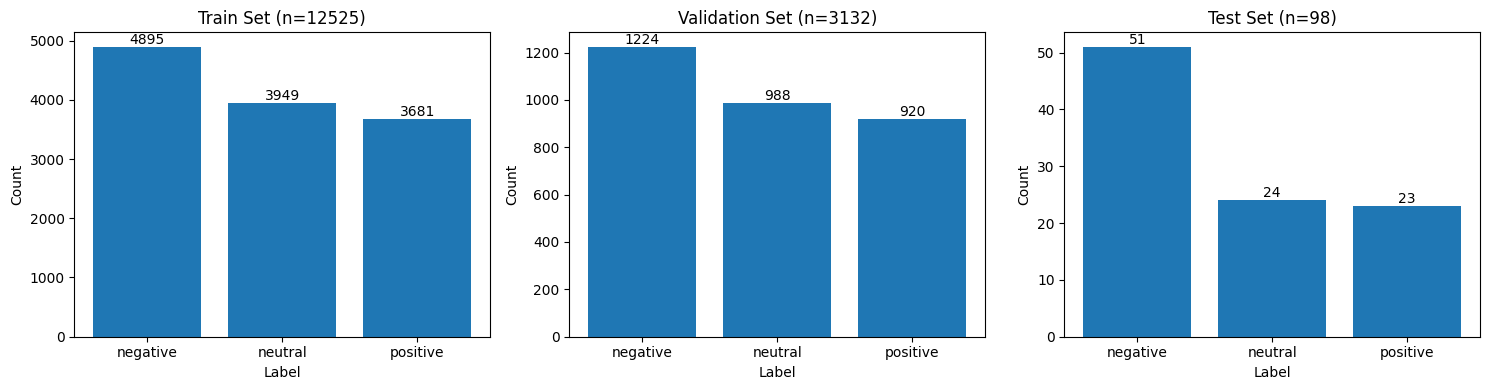


Class weights (for handling imbalance): [0.85291113 1.05722968 1.13420266]

DATA QUALITY CHECKS

Text length statistics (characters):
Train - Min: 2, Max: 184, Mean: 74.6
Validation - Min: 3, Max: 144, Mean: 74.3
Test - Min: 21, Max: 128, Mean: 81.5

Text length statistics (characters):
Train - Min: 2, Max: 184, Mean: 74.6
Validation - Min: 3, Max: 144, Mean: 74.3
Test - Min: 21, Max: 128, Mean: 81.5

Train: 2, Validation: 0, Test: 0

Sample texts from each set:

Train sample:
  1. ونبه فضيلته من مايبث عبر القنوات الفضاييه من برامج ومسلسلات هابطهتهدم اخلاق الفرد والمجتمع وتنشرالفس... (label: positive)
  2. وتظن انك لن تنجو فلا تدري الا ويرزقك اله سعاده تنسيك كل حزن مرت به... (label: neutral)

Validation sample:
  1. الماليه تحث ذوي المتوفين المستفيدين باعفاء القروض علي التقدم بطلب عبر موقعها... (label: positive)
  2. خادم الحرمين الشريفين يعزي الرييس التركي في ضحايا الهجوم الارهابي الذي وقع في انقره... (label: positive)

Test sample:
  1. مطار حمد الدولي ينضم لنادي الخمس نجوم مبروك لا

In [11]:

import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight


# Check for exact duplicates
def check_exact_duplicates(train_df, val_df, test_df, text_col='cleaned_text'):

    train_texts = set(train_df[text_col])
    val_texts = set(val_df[text_col])
    test_texts = set(test_df[text_col])

    train_val_dups = train_texts.intersection(val_texts)
    train_test_dups = train_texts.intersection(test_texts)
    val_test_dups = val_texts.intersection(test_texts)

    return {
        'train_val_exact_dups': len(train_val_dups),
        'train_test_exact_dups': len(train_test_dups),
        'val_test_exact_dups': len(val_test_dups),
        'train_val_dup_examples': list(train_val_dups)[:3] if train_val_dups else [],
        'train_test_dup_examples': list(train_test_dups)[:3] if train_test_dups else [],
        'val_test_dup_examples': list(val_test_dups)[:3] if val_test_dups else []
    }

def check_data_leakage(train_texts, val_texts, test_texts, threshold=0.9):
    """Check for overlapping texts between splits using TF-IDF similarity"""
    from sklearn.feature_extraction.text import TfidfVectorizer
    import scipy.sparse as sp

    vectorizer = TfidfVectorizer(max_features=5000)
    all_texts = list(train_texts) + list(val_texts) + list(test_texts)

    # Create a matrix where each row is a document
    X = vectorizer.fit_transform(all_texts)

    # Check for duplicates
    n_train = len(train_texts)
    n_val = len(val_texts)
    n_test = len(test_texts)

    results = {}

    # Check train-val overlap
    train_matrix = X[:n_train]
    val_matrix = X[n_train:n_train+n_val]
    similarity = train_matrix @ val_matrix.T
    max_similarities = similarity.max(axis=1).toarray().flatten()
    results['train_val_max_sim'] = max_similarities.max()
    results['train_val_high_sim'] = (max_similarities > threshold).sum()

    # Check train-test overlap
    test_matrix = X[n_train+n_val:]
    similarity = train_matrix @ test_matrix.T
    max_similarities = similarity.max(axis=1).toarray().flatten()
    results['train_test_max_sim'] = max_similarities.max()
    results['train_test_high_sim'] = (max_similarities > threshold).sum()

    # Check val-test overlap
    similarity = val_matrix @ test_matrix.T
    max_similarities = similarity.max(axis=1).toarray().flatten()
    results['val_test_max_sim'] = max_similarities.max()
    results['val_test_high_sim'] = (max_similarities > threshold).sum()

    return results


def plot_label_distribution(train_labels, val_labels, test_labels):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    splits = ['Train', 'Validation', 'Test']
    label_data = [train_labels, val_labels, test_labels]

    for idx, (ax, split_name, labels) in enumerate(zip(axes, splits, label_data)):
        unique, counts = np.unique(labels, return_counts=True)
        ax.bar([mapping(l) for l in unique], counts)
        ax.set_title(f'{split_name} Set (n={len(labels)})')
        ax.set_xlabel('Label')
        ax.set_ylabel('Count')
        for i, v in enumerate(counts):
            ax.text(i, v + max(counts)*0.01, str(v), ha='center')

    plt.tight_layout()
    plt.show()


def data_preprocess():
    # Load and prepare data
    print("="*60)
    print("DATA PREPARATION")
    print("="*60)

    train_data = pd.read_excel("AraSenti_all.xlsx")
    test_data = pd.read_excel("HIAQatar_tweets.xlsx")

    print(f"Original train data size: {len(train_data)}")
    print(f"Original test data size: {len(test_data)}")

    # Clean data
    print("\nCleaning data...")
    train_data['cleaned_text'] = train_data['tweet'].apply(clean_tweet)
    test_data['cleaned_text'] = test_data['tweet'].apply(clean_tweet)

    train_data = train_data.dropna(subset=['cleaned_text', 'label'])
    test_data = test_data.dropna(subset=['cleaned_text', 'label'])

    # Remove empty strings
    train_data = train_data[train_data['cleaned_text'].str.strip() != '']
    test_data = test_data[test_data['cleaned_text'].str.strip() != '']

    # Remove duplicates
    print("\nRemoving duplicates...")
    train_data = train_data.drop_duplicates(subset=['cleaned_text'])
    test_data = test_data.drop_duplicates(subset=['cleaned_text'])

    print(f"After cleaning - Train size: {len(train_data)}")
    print(f"After cleaning - Test size: {len(test_data)}")

    print("\nSplitting data...")
    train_df, val_df = train_test_split(
        train_data,
        test_size=0.2,
        random_state=42,
        stratify=train_data['label']
    )

    print(f"Train size: {len(train_df)}")
    print(f"Validation size: {len(val_df)}")
    print(f"Test size: {len(test_data)}")


    # ============ DATA LEAKAGE CHECK ============
    print("\n" + "="*60)
    print("DATA LEAKAGE CHECK")
    print("="*60)

    exact_dup_results = check_exact_duplicates(train_df, val_df, test_data, text_col='cleaned_text')
    print("\nExact duplicates check:")
    print(f"Train-Val exact duplicates: {exact_dup_results['train_val_exact_dups']}")
    print(f"Train-Test exact duplicates: {exact_dup_results['train_test_exact_dups']}")
    print(f"Val-Test exact duplicates: {exact_dup_results['val_test_exact_dups']}")

    if exact_dup_results['train_val_exact_dups'] > 0:
        print("\nWARNING: Found exact duplicates between train and validation!")
        print("Examples:", exact_dup_results['train_val_dup_examples'][:3])

    if exact_dup_results['train_test_exact_dups'] > 0:
        print("\nWARNING: Found exact duplicates between train and test!")
        print("Examples:", exact_dup_results['train_test_dup_examples'][:3])

    if exact_dup_results['val_test_exact_dups'] > 0:
        print("\nWARNING: Found exact duplicates between validation and test!")
        print("Examples:", exact_dup_results['val_test_dup_examples'][:3])

    # Check similar texts (TF-IDF similarity)
    print("\nChecking for similar texts (TF-IDF similarity > 0.9)...")
    similarity_results = check_data_leakage(
        train_df['cleaned_text'],
        val_df['cleaned_text'],
        test_data['cleaned_text'],
        threshold=0.9
    )

    print(f"Max similarity train-val: {similarity_results['train_val_max_sim']:.4f}")
    print(f"Documents with >0.9 similarity train-val: {similarity_results['train_val_high_sim']}")
    print(f"Max similarity train-test: {similarity_results['train_test_max_sim']:.4f}")
    print(f"Documents with >0.9 similarity train-test: {similarity_results['train_test_high_sim']}")
    print(f"Max similarity val-test: {similarity_results['val_test_max_sim']:.4f}")
    print(f"Documents with >0.9 similarity val-test: {similarity_results['val_test_high_sim']}")

    # ============ LABEL DISTRIBUTION CHECK ============
    print("\n" + "="*60)
    print("LABEL DISTRIBUTION")
    print("="*60)

    train_labels = train_df['label'].values
    val_labels = val_df['label'].values
    test_labels = test_data['label'].values

    print("\nLabel counts:")
    print("Train:", pd.Series(train_labels).value_counts().sort_index().to_dict())
    print("Validation:", pd.Series(val_labels).value_counts().sort_index().to_dict())
    print("Test:", pd.Series(test_labels).value_counts().sort_index().to_dict())

    print("\nLabel percentages:")
    print("Train:", (pd.Series(train_labels).value_counts(normalize=True).sort_index() * 100).round(2).to_dict())
    print("Validation:", (pd.Series(val_labels).value_counts(normalize=True).sort_index() * 100).round(2).to_dict())
    print("Test:", (pd.Series(test_labels).value_counts(normalize=True).sort_index() * 100).round(2).to_dict())


    # Plot label distribution
    plot_label_distribution(train_labels, val_labels, test_labels)

    # Compute class weights for imbalanced data
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    print(f"\nClass weights (for handling imbalance): {class_weights}")

    # ============ DATA QUALITY CHECKS ============
    print("\n" + "="*60)
    print("DATA QUALITY CHECKS")
    print("="*60)

    # Check text lengths
    train_lengths = train_df['cleaned_text'].str.len()
    val_lengths = val_df['cleaned_text'].str.len()
    test_lengths = test_data['cleaned_text'].str.len()

    print(f"\nText length statistics (characters):")
    print(f"Train - Min: {train_lengths.min()}, Max: {train_lengths.max()}, Mean: {train_lengths.mean():.1f}")
    print(f"Validation - Min: {val_lengths.min()}, Max: {val_lengths.max()}, Mean: {val_lengths.mean():.1f}")
    print(f"Test - Min: {test_lengths.min()}, Max: {test_lengths.max()}, Mean: {test_lengths.mean():.1f}")


    # Check for very short texts
    short_threshold = 3
    train_short = (train_lengths < short_threshold).sum()
    val_short = (val_lengths < short_threshold).sum()
    test_short = (test_lengths < short_threshold).sum()
    print(f"\nText length statistics (characters):")
    print(f"Train - Min: {train_lengths.min()}, Max: {train_lengths.max()}, Mean: {train_lengths.mean():.1f}")
    print(f"Validation - Min: {val_lengths.min()}, Max: {val_lengths.max()}, Mean: {val_lengths.mean():.1f}")
    print(f"Test - Min: {test_lengths.min()}, Max: {test_lengths.max()}, Mean: {test_lengths.mean():.1f}")

    if train_short > 0 or val_short > 0 or test_short > 0:
        print(f"\nWARNING: Found very short texts (<{short_threshold} chars):")
        print(f"Train: {train_short}, Validation: {val_short}, Test: {test_short}")

    # Sample some texts for manual inspection
    print("\nSample texts from each set:")
    print("\nTrain sample:")
    for i in range(min(2, len(train_df))):
        print(f"  {i+1}. {train_df.iloc[i]['cleaned_text'][:100]}... (label: {mapping(train_df.iloc[i]['label'])})")

    print("\nValidation sample:")
    for i in range(min(2, len(val_df))):
        print(f"  {i+1}. {val_df.iloc[i]['cleaned_text'][:100]}... (label: {mapping(val_df.iloc[i]['label'])})")

    print("\nTest sample:")
    for i in range(min(2, len(test_data))):
        print(f"  {i+1}. {test_data.iloc[i]['cleaned_text'][:100]}... (label: {mapping(test_data.iloc[i]['label'])})")
    return train_df, val_df, test_data, class_weights





train_df, val_df, test_df, class_weights = data_preprocess()




In [ ]:

from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert = AutoModel.from_pretrained(MODEL_NAME)


bert.config.hidden_size


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


768

In [ ]:
# Bulid your Bidirectional LSTM with LLM embedding here
# 1) build datasets (train and test)
# 2) tokenize data
# 3) build the model
# 4) train the model
# 5) evaluate the model

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
MODEL_NAME = "CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment"


config = {
    'model_name': MODEL_NAME,
    # Since tweets are short texts, we limited the maximum sequence length to 128 tokens to reduce computational cost without affecting performance.
    'max_len': 128,
    'batch_size': 16,
    'num_epochs': 10,
    'learning_rate': 2e-5,
    'weight_decay': 1e-2,
    'hidden_size': 128,
    'num_layers': 2,
    'dropout': 0.3,
    'num_classes': 3

}
class SentimentDataset(Dataset):

    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }




def create_datasets(train_df, val_df, test_data, config, tokenizer):

    train_dataset = SentimentDataset(
        texts=list(train_df['cleaned_text']),
        labels=list(train_df['label']),
        tokenizer=tokenizer,
        max_len=config['max_len']
    )

    val_dataset = SentimentDataset(
        texts=list(val_df['cleaned_text']),
        labels=list(val_df['label']),
        tokenizer=tokenizer
    )

    test_dataset = SentimentDataset(
        texts=list(test_data['cleaned_text']),
        labels=list(test_data['label']),
        tokenizer=tokenizer
    )


    return train_dataset, val_dataset, test_dataset


seed()


tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_dataset, val_dataset, test_dataset = create_datasets(train_df, val_df, test_df, config, tokenizer)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)


print(f"Train Loader size: {len(train_loader)}")
print(f"Val Loader size: {len(val_loader)}")
print(f"Test Loader size: {len(test_loader)}")


test_batch = next(iter(train_loader))
test_batch
print(len(train_data))
print("Keys in batch:", test_batch.keys())


print("input_ids shape:", test_batch['input_ids'].shape)
print("attention_mask shape:", test_batch['attention_mask'].shape)
print("labels shape:", test_batch['labels'].shape)


decoded_text = tokenizer.decode(
    test_batch['input_ids'][0], skip_special_tokens=True)
print("Decoded text example:", decoded_text)

print("Label:", test_batch['labels'][0].item())
print("Label:", mapping(test_batch['labels'][0].item()))


Train Loader size: 783
Val Loader size: 196
Test Loader size: 7
15751
Keys in batch: dict_keys(['input_ids', 'attention_mask', 'labels'])
input_ids shape: torch.Size([16, 128])
attention_mask shape: torch.Size([16, 128])
labels shape: torch.Size([16])
Decoded text example: حصه بنت سلمان الاهتمام بالجمعيه والوقوف معها امتداد لعنايه خادم الحرمين بتعليم المراه
Label: 2
Label: positive


In [ ]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))


In [ ]:


seed()
loss_fn = nn.CrossEntropyLoss()

test_batch = next(iter(train_loader))
input_ids = test_batch['input_ids'].to(DEVICE)
attention_mask = test_batch['attention_mask'].to(DEVICE)
labels = test_batch['labels'].to(DEVICE)

bert = bert.to(DEVICE)
for params in bert.parameters():
    params.requires_grad = False

bert_hidden_size = bert.config.hidden_size

lstm = nn.LSTM(
    input_size=bert_hidden_size,
    hidden_size=config['hidden_size'],
    num_layers=config['num_layers'],
    batch_first=True,
    dropout=config['dropout'],
    bidirectional=True

).to(DEVICE)


attention = nn.Linear(config['hidden_size'] * 2, 1).to(DEVICE)
norm = nn.LayerNorm(config['hidden_size'] * 2).to(DEVICE)
fc = nn.Linear(config['hidden_size'] * 2, config['num_classes']).to(DEVICE)

dropout1 = nn.Dropout(config['dropout']).to(DEVICE)
dropout2 = nn.Dropout(config['dropout']).to(DEVICE)


# [batch_size, seq_len, bert_hidden_size]
out = bert(input_ids=input_ids, attention_mask=attention_mask)

# [batch_size, seq_len, hidden_size*2]
lstm_out, _ = lstm(out.last_hidden_state)
print(lstm_out.shape)
lstm_out_norm = norm(lstm_out)
attention_scores = attention(lstm_out_norm)  # [batch_size, seq_len, 1]

# Convert scores to probabilities using softmax
attention_weights = torch.softmax( attention_scores, dim=1)  # [batch_size, seq_len, 1]
attention_weights.shape

# Element-wise multiplication (broadcasting)
# [batch_size, seq_len, hidden_size*2]
weighted_outputs = attention_weights * lstm_out

# Sum across sequence dimension to get context vector
# [batch_size, hidden_size*2]
context_vector = torch.sum(weighted_outputs, dim=1)

# context_vector = norm(context_vector)
context_vector = dropout2(context_vector)


logits = fc(context_vector)  # [batch_size, num_classes]


loss = loss_fn(logits, labels)
print(loss)


torch.Size([16, 128, 256])
tensor(1.0971, device='cuda:0', grad_fn=<NllLossBackward0>)


In [ ]:

import numpy as np

import torch
import torch.nn as nn

from transformers import AutoModel

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tqdm import tqdm
from torch.optim import AdamW
from sklearn.utils.class_weight import compute_class_weight


class BiLSTMWithLLM(nn.Module):
    def __init__(self, model_name, hidden_size, num_layers, dropout, num_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)

        # Freeze first N layers
        for param in self.bert.parameters():
            param.requires_grad = False


        bert_hidden_size = self.bert.config.hidden_size

        # BiLSTM with dropout
        self.lstm = nn.LSTM(
            input_size=bert_hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Attention mechanism
        self.attention = nn.Linear(hidden_size * 2, 1)
        self.norm = nn.LayerNorm(hidden_size * 2)

        # Better classifier with LayerNorm
        self.classifier = nn.Sequential(
            nn.LayerNorm(hidden_size * 2),
            nn.Dropout(dropout),
            nn.Linear(hidden_size * 2, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        # Get BERT embeddings
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state

        # LSTM
        lstm_out, _ = self.lstm(sequence_output)

        lstm_out = self.norm(lstm_out)

        # Attention
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)

        # Classification
        logits = self.classifier(context_vector)
        return logits


def train_model(model, train_loader, val_loader, optimizer, criterion, device):

    model.train()
    total_train_loss = 0
    train_loop = tqdm(train_loader, desc="Train", leave=True)

    for batch in train_loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        train_loop.set_postfix(train_loss=f"{loss.item():.4f}")

    avg_train_loss = total_train_loss / len(train_loader)

    model.eval()
    total_val_loss = 0
    val_preds = []
    val_labels = []
    val_loop = tqdm(val_loader, desc="Val", leave=True)

    with torch.no_grad():
        for batch in val_loop:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)

            total_val_loss += loss.item()
            _, preds = torch.max(logits, dim=1)

            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

            batch_acc = (preds == labels).float().mean().item()
            val_loop.set_postfix(
                val_loss=f"{loss.item():.4f}", batch_acc=f"{batch_acc:.4f}")

    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, average='weighted')

    return avg_train_loss, avg_val_loss, val_acc, val_f1


def test_model(model, dataloader):
    model.eval()
    predictions = []
    true_labels = []

    loop = tqdm(dataloader, desc="Evaluating", leave=True)

    with torch.no_grad():
        for batch in loop:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)
            logits = model(input_ids, attention_mask)
            _, preds = torch.max(logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            batch_acc = (preds == labels).float().mean().item()
            loop.set_postfix(batch_accuracy=f"{batch_acc:.4f}")

    accuracy = accuracy_score(true_labels, predictions)

    f1 = f1_score(true_labels, predictions, average='weighted')
    cm = confusion_matrix(true_labels, predictions)
    return accuracy, f1, cm


seed()


config = {
    'model_name': MODEL_NAME,
    'max_len': 128,
    'batch_size': 8,
    'num_epochs': 10,
    'learning_rate': 2e-5,
    'weight_decay': 1e-2,
    'hidden_size': 128,
    'num_layers': 2,
    'dropout': 0.1,
    'num_classes': 3

}

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)


print(f"Train Loader size: {len(train_loader)}")
print(f"Val Loader size: {len(val_loader)}")
print(f"Test Loader size: {len(test_loader)}")



model = BiLSTMWithLLM(
    model_name=config['model_name'],
    hidden_size=config['hidden_size'],
    num_layers=config['num_layers'],
    dropout=config['dropout'],
    num_classes=config['num_classes']
).to(DEVICE)


criterion = nn.CrossEntropyLoss()


optimizer = AdamW(
    model.parameters(),
    lr=config['learning_rate'],
    weight_decay=config['weight_decay']
)


best_accuracy = 0.0


for epoch in range(config['num_epochs']):
    train_loss, val_loss, val_acc, val_f1 = train_model(
        model, train_loader, val_loader, optimizer, criterion, DEVICE
    )

    print(f"Epoch {epoch+1}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss:   {val_loss:.4f}")
    print(f"Val Acc:    {val_acc:.4f}")
    print(f"Val F1:     {val_f1:.4f}")
    print("-" * 50)
    print()

    test_accuracy, test_f1, test_cm = test_model(model, test_loader)
    if best_accuracy < test_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Saving best model weights")

    print("TEST RESULTS")
    print("-" * 50)
    print(f"TEST Accuracy: {test_accuracy:.4f}")
    print(f"TEST F1 Score: {test_f1:.4f}")
    print("TEST Confusion Matrix:")
    print(test_cm)
    print("-" * 50)
    print()




Train Loader size: 1566
Val Loader size: 392
Test Loader size: 13


Val: 100%|██████████| 392/392 [00:23<00:00, 16.38it/s, batch_acc=1.0000, val_loss=0.0139]


Epoch 1
Train Loss: 0.4753
Val Loss:   0.3659
Val Acc:    0.8582
Val F1:     0.8584
--------------------------------------------------



Evaluating: 100%|██████████| 13/13 [00:00<00:00, 13.14it/s, batch_accuracy=0.5000]


Saving best model weights
TEST RESULTS
--------------------------------------------------
TEST Accuracy: 0.8163
TEST F1 Score: 0.8188
TEST Confusion Matrix:
[[40  5  6]
 [ 2 19  3]
 [ 1  1 21]]
--------------------------------------------------



Val: 100%|██████████| 392/392 [00:24<00:00, 16.32it/s, batch_acc=1.0000, val_loss=0.0089]


Epoch 2
Train Loss: 0.3545
Val Loss:   0.3252
Val Acc:    0.8716
Val F1:     0.8717
--------------------------------------------------



Evaluating: 100%|██████████| 13/13 [00:00<00:00, 13.29it/s, batch_accuracy=0.5000]


Saving best model weights
TEST RESULTS
--------------------------------------------------
TEST Accuracy: 0.8265
TEST F1 Score: 0.8298
TEST Confusion Matrix:
[[44  3  4]
 [ 1 18  5]
 [ 2  2 19]]
--------------------------------------------------



Val: 100%|██████████| 392/392 [00:24<00:00, 16.32it/s, batch_acc=1.0000, val_loss=0.0094]


Epoch 3
Train Loss: 0.3120
Val Loss:   0.3102
Val Acc:    0.8806
Val F1:     0.8811
--------------------------------------------------



Evaluating: 100%|██████████| 13/13 [00:00<00:00, 13.27it/s, batch_accuracy=1.0000]


TEST RESULTS
--------------------------------------------------
TEST Accuracy: 0.7755
TEST F1 Score: 0.7817
TEST Confusion Matrix:
[[38  8  5]
 [ 0 19  5]
 [ 2  2 19]]
--------------------------------------------------



Train:   4%|▍         | 66/1566 [00:04<01:48, 13.86it/s, train_loss=0.1957]


KeyboardInterrupt: 

In [ ]:
best_accuracy

0.826530612244898

In [ ]:

import numpy as np

import torch
import torch.nn as nn

from transformers import AutoModel

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tqdm import tqdm
from torch.optim import AdamW
from sklearn.utils.class_weight import compute_class_weight

#  trying to change the Classification laysers


class BiLSTMWithLLM(nn.Module):
    def __init__(self, model_name, hidden_size, num_layers, dropout, num_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)

        # Freeze first N layers
        for param in self.bert.parameters():
            param.requires_grad = False


        bert_hidden_size = self.bert.config.hidden_size

        # BiLSTM with dropout
        self.lstm = nn.LSTM(
            input_size=bert_hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

        # Classification head with more layers
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        # Get BERT embeddings
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state

        # LSTM
        lstm_out, _ = self.lstm(sequence_output)

        # Attention
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)

        # Classification
        logits = self.classifier(context_vector)
        return logits


def train_model(model, train_loader, val_loader, optimizer, criterion, device):

    model.train()
    total_train_loss = 0
    train_loop = tqdm(train_loader, desc="Train", leave=True)

    for batch in train_loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        train_loop.set_postfix(train_loss=f"{loss.item():.4f}")

    avg_train_loss = total_train_loss / len(train_loader)

    model.eval()
    total_val_loss = 0
    val_preds = []
    val_labels = []
    val_loop = tqdm(val_loader, desc="Val", leave=True)

    with torch.no_grad():
        for batch in val_loop:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)

            total_val_loss += loss.item()
            _, preds = torch.max(logits, dim=1)

            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

            batch_acc = (preds == labels).float().mean().item()
            val_loop.set_postfix(
                val_loss=f"{loss.item():.4f}", batch_acc=f"{batch_acc:.4f}")

    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, average='weighted')

    return avg_train_loss, avg_val_loss, val_acc, val_f1


def test_model(model, dataloader):
    model.eval()
    predictions = []
    true_labels = []

    loop = tqdm(dataloader, desc="Evaluating", leave=True)

    with torch.no_grad():
        for batch in loop:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)
            logits = model(input_ids, attention_mask)
            _, preds = torch.max(logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            batch_acc = (preds == labels).float().mean().item()
            loop.set_postfix(batch_accuracy=f"{batch_acc:.4f}")

    accuracy = accuracy_score(true_labels, predictions)

    f1 = f1_score(true_labels, predictions, average='weighted')
    cm = confusion_matrix(true_labels, predictions)
    return accuracy, f1, cm


seed()


config = {
    'model_name': MODEL_NAME,
    'max_len': 128,
    'batch_size': 8,
    'num_epochs': 10,
    'learning_rate': 2e-5,
    'weight_decay': 1e-2,
    'hidden_size': 128,
    'num_layers': 2,
    'dropout': 0.1,
    'num_classes': 3

}

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)


print(f"Train Loader size: {len(train_loader)}")
print(f"Val Loader size: {len(val_loader)}")
print(f"Test Loader size: {len(test_loader)}")



model = BiLSTMWithLLM(
    model_name=config['model_name'],
    hidden_size=config['hidden_size'],
    num_layers=config['num_layers'],
    dropout=config['dropout'],
    num_classes=config['num_classes']
).to(DEVICE)


criterion = nn.CrossEntropyLoss()


optimizer = AdamW(
    model.parameters(),
    lr=config['learning_rate'],
    weight_decay=config['weight_decay']
)


best_accuracy = 0.0


for epoch in range(config['num_epochs']):
    train_loss, val_loss, val_acc, val_f1 = train_model(
        model, train_loader, val_loader, optimizer, criterion, DEVICE
    )

    print(f"Epoch {epoch+1}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss:   {val_loss:.4f}")
    print(f"Val Acc:    {val_acc:.4f}")
    print(f"Val F1:     {val_f1:.4f}")
    print("-" * 50)
    print()

    test_accuracy, test_f1, test_cm = test_model(model, test_loader)
    if best_accuracy < test_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Saving best model weights")

    print("TEST RESULTS")
    print("-" * 50)
    print(f"TEST Accuracy: {test_accuracy:.4f}")
    print(f"TEST F1 Score: {test_f1:.4f}")
    print("TEST Confusion Matrix:")
    print(test_cm)
    print("-" * 50)
    print()




Train Loader size: 1566
Val Loader size: 392
Test Loader size: 13


Val: 100%|██████████| 392/392 [00:23<00:00, 16.38it/s, batch_acc=1.0000, val_loss=0.0242]


Epoch 1
Train Loss: 0.5581
Val Loss:   0.3773
Val Acc:    0.8566
Val F1:     0.8568
--------------------------------------------------



Evaluating: 100%|██████████| 13/13 [00:01<00:00, 12.68it/s, batch_accuracy=0.5000]


Saving best model weights
TEST RESULTS
--------------------------------------------------
TEST Accuracy: 0.8367
TEST F1 Score: 0.8374
TEST Confusion Matrix:
[[45  3  3]
 [ 2 19  3]
 [ 3  2 18]]
--------------------------------------------------



Val: 100%|██████████| 392/392 [00:24<00:00, 16.28it/s, batch_acc=1.0000, val_loss=0.0105]


Epoch 2
Train Loss: 0.3632
Val Loss:   0.3284
Val Acc:    0.8736
Val F1:     0.8736
--------------------------------------------------



Evaluating: 100%|██████████| 13/13 [00:01<00:00, 12.49it/s, batch_accuracy=1.0000]


TEST RESULTS
--------------------------------------------------
TEST Accuracy: 0.8163
TEST F1 Score: 0.8228
TEST Confusion Matrix:
[[41  2  8]
 [ 0 20  4]
 [ 3  1 19]]
--------------------------------------------------



Val: 100%|██████████| 392/392 [00:24<00:00, 16.29it/s, batch_acc=1.0000, val_loss=0.0074]


Epoch 3
Train Loss: 0.3256
Val Loss:   0.3129
Val Acc:    0.8777
Val F1:     0.8780
--------------------------------------------------



Evaluating: 100%|██████████| 13/13 [00:01<00:00, 12.41it/s, batch_accuracy=1.0000]


TEST RESULTS
--------------------------------------------------
TEST Accuracy: 0.7755
TEST F1 Score: 0.7851
TEST Confusion Matrix:
[[37  3 11]
 [ 0 20  4]
 [ 1  3 19]]
--------------------------------------------------



Val: 100%|██████████| 392/392 [00:24<00:00, 16.29it/s, batch_acc=1.0000, val_loss=0.0050]


Epoch 4
Train Loss: 0.2986
Val Loss:   0.3001
Val Acc:    0.8892
Val F1:     0.8894
--------------------------------------------------



Evaluating: 100%|██████████| 13/13 [00:01<00:00, 12.43it/s, batch_accuracy=1.0000]


TEST RESULTS
--------------------------------------------------
TEST Accuracy: 0.8265
TEST F1 Score: 0.8308
TEST Confusion Matrix:
[[43  2  6]
 [ 0 20  4]
 [ 4  1 18]]
--------------------------------------------------



Val: 100%|██████████| 392/392 [00:24<00:00, 16.18it/s, batch_acc=1.0000, val_loss=0.0046]


Epoch 5
Train Loss: 0.2700
Val Loss:   0.3006
Val Acc:    0.8847
Val F1:     0.8851
--------------------------------------------------



Evaluating: 100%|██████████| 13/13 [00:01<00:00, 11.22it/s, batch_accuracy=1.0000]


TEST RESULTS
--------------------------------------------------
TEST Accuracy: 0.7959
TEST F1 Score: 0.8036
TEST Confusion Matrix:
[[39  4  8]
 [ 0 19  5]
 [ 1  2 20]]
--------------------------------------------------



Val: 100%|██████████| 392/392 [00:24<00:00, 16.31it/s, batch_acc=1.0000, val_loss=0.0033]


Epoch 6
Train Loss: 0.2510
Val Loss:   0.3218
Val Acc:    0.8803
Val F1:     0.8809
--------------------------------------------------



Evaluating: 100%|██████████| 13/13 [00:01<00:00, 12.48it/s, batch_accuracy=1.0000]


TEST RESULTS
--------------------------------------------------
TEST Accuracy: 0.7653
TEST F1 Score: 0.7709
TEST Confusion Matrix:
[[38  8  5]
 [ 0 20  4]
 [ 3  3 17]]
--------------------------------------------------



Val: 100%|██████████| 392/392 [00:24<00:00, 16.03it/s, batch_acc=1.0000, val_loss=0.0023]


Epoch 7
Train Loss: 0.2371
Val Loss:   0.3060
Val Acc:    0.8889
Val F1:     0.8889
--------------------------------------------------



Evaluating: 100%|██████████| 13/13 [00:01<00:00, 10.62it/s, batch_accuracy=1.0000]


TEST RESULTS
--------------------------------------------------
TEST Accuracy: 0.8163
TEST F1 Score: 0.8202
TEST Confusion Matrix:
[[42  2  7]
 [ 1 20  3]
 [ 4  1 18]]
--------------------------------------------------



Val: 100%|██████████| 392/392 [00:24<00:00, 16.29it/s, batch_acc=1.0000, val_loss=0.0023]


Epoch 8
Train Loss: 0.2176
Val Loss:   0.3009
Val Acc:    0.8930
Val F1:     0.8931
--------------------------------------------------



Evaluating: 100%|██████████| 13/13 [00:01<00:00, 12.55it/s, batch_accuracy=1.0000]


TEST RESULTS
--------------------------------------------------
TEST Accuracy: 0.7653
TEST F1 Score: 0.7726
TEST Confusion Matrix:
[[38  3 10]
 [ 0 20  4]
 [ 5  1 17]]
--------------------------------------------------



Val: 100%|██████████| 392/392 [00:24<00:00, 16.24it/s, batch_acc=1.0000, val_loss=0.0016]


Epoch 9
Train Loss: 0.2056
Val Loss:   0.3108
Val Acc:    0.8889
Val F1:     0.8891
--------------------------------------------------



Evaluating: 100%|██████████| 13/13 [00:01<00:00, 11.15it/s, batch_accuracy=1.0000]


TEST RESULTS
--------------------------------------------------
TEST Accuracy: 0.7959
TEST F1 Score: 0.8023
TEST Confusion Matrix:
[[39  4  8]
 [ 0 20  4]
 [ 2  2 19]]
--------------------------------------------------



Val: 100%|██████████| 392/392 [00:23<00:00, 16.34it/s, batch_acc=1.0000, val_loss=0.0013]


Epoch 10
Train Loss: 0.1903
Val Loss:   0.3089
Val Acc:    0.8914
Val F1:     0.8916
--------------------------------------------------



Evaluating: 100%|██████████| 13/13 [00:01<00:00, 12.54it/s, batch_accuracy=1.0000]

TEST RESULTS
--------------------------------------------------
TEST Accuracy: 0.8061
TEST F1 Score: 0.8124
TEST Confusion Matrix:
[[41  3  7]
 [ 0 19  5]
 [ 3  1 19]]
--------------------------------------------------



In [ ]:
best_accuracy


0.8367346938775511

In [ ]:

model = BiLSTMWithLLM(
    model_name=config['model_name'],
    hidden_size=config['hidden_size'],
    num_layers=config['num_layers'],
    dropout=config['dropout'],
    num_classes=config['num_classes']
).to(DEVICE)


model.load_state_dict(torch.load('best_model.pth'))


model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)
        logits = model(input_ids, attention_mask)
        _, preds = torch.max(logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        batch_acc = (preds == labels).float().mean().item()

    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')
    cm = confusion_matrix(true_labels, predictions)
    print("TEST RESULTS")
    print("-" * 50)
    print(f"TEST Accuracy: {accuracy:.4f}")
    print(f"TEST F1 Score: {f1:.4f}")
    print("TEST Confusion Matrix:")
    print(cm)
    print("-" * 50)
    print()


TEST RESULTS
--------------------------------------------------
TEST Accuracy: 0.8367
TEST F1 Score: 0.8374
TEST Confusion Matrix:
[[45  3  3]
 [ 2 19  3]
 [ 3  2 18]]
--------------------------------------------------



## Part (2) LLM for Arabic SA


In [12]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader


In [13]:
import re
# Data preprocessing function
# In this function you should clean the Arabic text and normlize it
# remove repeated letter, english letter, punctuation, etc.
# Input: unclean tweet
# Output: clean tweet


def clean_tweet(tweet):
    # remove english letters
    tweet = re.sub(r'[a-zA-Z0-9]+', '', tweet, flags=re.MULTILINE)
    '''
    write your code here
    '''
    return tweet


In [39]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_NAME = "CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment"
from datasets import Dataset

train = Dataset.from_pandas(train_df)
val   = Dataset.from_pandas(val_df)
test  = Dataset.from_pandas(test_df)
train.take(4)

Dataset({
    features: ['tweet', 'label', 'cleaned_text', '__index_level_0__'],
    num_rows: 4
})

In [41]:
# Bulid your Bidirectional LSTM with LLM embedding here
# 1) build datasets (train and test)
# 2) call tokenizer and pre-trained model
# 3) prepare trainer
# 4) train the model (call trainer)
# 5) evaluate the model


import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset





def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }

def tokenize_function(batch):
    tokens = tokenizer(
        batch["cleaned_text"],
        truncation=True,
        padding="max_length",
        max_length=config["max_len"]
    )
    tokens["labels"] = batch["label"]
    return tokens


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_NAME = "CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment"



model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3
).to(DEVICE)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    return_tensors="pt"
)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none"
)




train_dataset = train.map(
    tokenize_function,
    batched=True,
    remove_columns=train.column_names
)

val_dataset = val.map(
    tokenize_function,
    batched=True,
    remove_columns=val.column_names
)

test_dataset = test.map(
    tokenize_function,
    batched=True,
    remove_columns=test.column_names
)



trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

Map:   0%|          | 0/12562 [00:00<?, ? examples/s]

Map:   0%|          | 0/3141 [00:00<?, ? examples/s]

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.342900,0.219268,0.934734,0.934306
2,0.119000,0.270952,0.933461,0.932130
3,0.059000,0.346156,0.939510,0.938522
4,0.016300,0.371420,0.941420,0.940528
5,0.008200,0.390731,0.941420,0.940334


TrainOutput(global_step=3930, training_loss=0.09423793150875101, metrics={'train_runtime': 1665.1954, 'train_samples_per_second': 37.719, 'train_steps_per_second': 2.36, 'total_flos': 4131538441873920.0, 'train_loss': 0.09423793150875101, 'epoch': 5.0})

In [42]:
trainer.evaluate(test_dataset)


{'eval_loss': 2.44217586517334,
 'eval_accuracy': 0.6868686868686869,
 'eval_f1_macro': 0.6822229910685683,
 'eval_runtime': 0.7878,
 'eval_samples_per_second': 125.671,
 'eval_steps_per_second': 8.886,
 'epoch': 5.0}

##: Fine-Tuning without using Trainer

In [ ]:



def train_model(model, train_loader, val_loader, optimizer, criterion, device):

    model.train()
    total_train_loss = 0
    train_loop = tqdm(train_loader, desc="Train", leave=True)

    for batch in train_loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        logits = outputs.logits
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        train_loop.set_postfix(train_loss=f"{loss.item():.4f}")

    avg_train_loss = total_train_loss / len(train_loader)

    model.eval()
    total_val_loss = 0
    val_preds = []
    val_labels = []
    val_loop = tqdm(val_loader, desc="Val", leave=True)

    with torch.no_grad():
        for batch in val_loop:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)


            outputs = model(input_ids, attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)

            total_val_loss += loss.item()
            _, preds = torch.max(logits, dim=1)

            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

            batch_acc = (preds == labels).float().mean().item()
            val_loop.set_postfix(
                val_loss=f"{loss.item():.4f}", batch_acc=f"{batch_acc:.4f}")

    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, average='weighted')

    return avg_train_loss, avg_val_loss, val_acc, val_f1


def test_model(model, dataloader):
    model.eval()
    predictions = []
    true_labels = []

    loop = tqdm(dataloader, desc="Evaluating", leave=True)

    with torch.no_grad():
        for batch in loop:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)
            outputs = model(input_ids, attention_mask)
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            batch_acc = (preds == labels).float().mean().item()
            loop.set_postfix(batch_accuracy=f"{batch_acc:.4f}")

    accuracy = accuracy_score(true_labels, predictions)

    f1 = f1_score(true_labels, predictions, average='weighted')
    cm = confusion_matrix(true_labels, predictions)
    return accuracy, f1, cm


model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3
).to(DEVICE)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
train_dataset, val_dataset, test_dataset = create_datasets(train_df, val_df, test_df, config, tokenizer)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)



criterion = nn.CrossEntropyLoss()
optimizer = AdamW(
    model.parameters(),
    lr=config['learning_rate'],
    weight_decay=config['weight_decay']
)



config['num_epochs'] = 4

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)
        logits = model(input_ids, attention_mask)
        _, preds = torch.max(logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        batch_acc = (preds == labels).float().mean().item()

    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')
    cm = confusion_matrix(true_labels, predictions)
    print("TEST RESULTS")
    print("-" * 50)
    print(f"TEST Accuracy: {accuracy:.4f}")
    print(f"TEST F1 Score: {f1:.4f}")
    print("TEST Confusion Matrix:")
    print(cm)
    print("-" * 50)
    print()



test_accuracy, test_f1, test_cm = test_model(model, test_loader)
print("TEST RESULTS")
print("-" * 50)
print(f"TEST Accuracy: {test_accuracy:.4f}")
print(f"TEST F1 Score: {test_f1:.4f}")
print("TEST Confusion Matrix:")
print(test_cm)
print("-" * 50)

Val: 100%|██████████| 196/196 [00:23<00:00,  8.34it/s, batch_acc=0.9167, val_loss=0.3661]


Epoch 1
Train Loss: 0.3311
Val Loss:   0.2187
Val Acc:    0.9237
Val F1:     0.9237
--------------------------------------------------



Val: 100%|██████████| 196/196 [00:23<00:00,  8.32it/s, batch_acc=0.9167, val_loss=0.2629]


Epoch 2
Train Loss: 0.1258
Val Loss:   0.2303
Val Acc:    0.9227
Val F1:     0.9228
--------------------------------------------------



Val: 100%|██████████| 196/196 [00:23<00:00,  8.34it/s, batch_acc=0.9167, val_loss=0.3053]


Epoch 3
Train Loss: 0.0489
Val Loss:   0.3384
Val Acc:    0.9221
Val F1:     0.9222
--------------------------------------------------



Val: 100%|██████████| 196/196 [00:23<00:00,  8.33it/s, batch_acc=0.9167, val_loss=0.4999]


Epoch 4
Train Loss: 0.0333
Val Loss:   0.3002
Val Acc:    0.9208
Val F1:     0.9209
--------------------------------------------------



Evaluating: 100%|██████████| 7/7 [00:00<00:00,  9.60it/s, batch_accuracy=1.0000]

TEST RESULTS
--------------------------------------------------
TEST Accuracy: 0.7041
TEST F1 Score: 0.7090
TEST Confusion Matrix:
[[31  7 13]
 [ 0 22  2]
 [ 2  5 16]]
--------------------------------------------------


In [ ]:

for epoch in range(config['num_epochs']):
    train_loss, val_loss, val_acc, val_f1 = train_model(
        model, train_loader, val_loader, optimizer, criterion, DEVICE
    )

    print(f"Epoch {epoch+1}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss:   {val_loss:.4f}")
    print(f"Val Acc:    {val_acc:.4f}")
    print(f"Val F1:     {val_f1:.4f}")
    print("-" * 50)
    print()

    test_accuracy, test_f1, test_cm = test_model(model, test_loader)
    if best_accuracy < test_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Saving best model weights")

    print("TEST RESULTS")
    print("-" * 50)
    print(f"TEST Accuracy: {test_accuracy:.4f}")
    print(f"TEST F1 Score: {test_f1:.4f}")
    print("TEST Confusion Matrix:")
    print(test_cm)
    print("-" * 50)
    print()



model.load_state_dict(torch.load('best_model.pth'))

test_accuracy, test_f1, test_cm = test_model(model, test_loader)
print("TEST RESULTS")
print("-" * 50)
print(f"TEST Accuracy: {test_accuracy:.4f}")
print(f"TEST F1 Score: {test_f1:.4f}")
print("TEST Confusion Matrix:")
print(test_cm)
print("-" * 50)

Val: 100%|██████████| 196/196 [00:25<00:00,  7.58it/s, batch_acc=0.9167, val_loss=0.5067]


Epoch 1
Train Loss: 0.0185
Val Loss:   0.3499
Val Acc:    0.9208
Val F1:     0.9209
--------------------------------------------------



Evaluating: 100%|██████████| 7/7 [00:00<00:00,  9.36it/s, batch_accuracy=1.0000]


TEST RESULTS
--------------------------------------------------
TEST Accuracy: 0.6837
TEST F1 Score: 0.6933
TEST Confusion Matrix:
[[31  7 13]
 [ 0 18  6]
 [ 3  2 18]]
--------------------------------------------------



Val: 100%|██████████| 196/196 [00:25<00:00,  7.63it/s, batch_acc=0.9167, val_loss=0.3525]


Epoch 2
Train Loss: 0.0166
Val Loss:   0.3580
Val Acc:    0.9221
Val F1:     0.9221
--------------------------------------------------



Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.97it/s, batch_accuracy=1.0000]


TEST RESULTS
--------------------------------------------------
TEST Accuracy: 0.7041
TEST F1 Score: 0.7133
TEST Confusion Matrix:
[[32  7 12]
 [ 0 18  6]
 [ 2  2 19]]
--------------------------------------------------



Val: 100%|██████████| 196/196 [00:25<00:00,  7.61it/s, batch_acc=0.9167, val_loss=0.7703]


Epoch 3
Train Loss: 0.0113
Val Loss:   0.4697
Val Acc:    0.9154
Val F1:     0.9154
--------------------------------------------------



Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.46it/s, batch_accuracy=1.0000]


TEST RESULTS
--------------------------------------------------
TEST Accuracy: 0.7347
TEST F1 Score: 0.7410
TEST Confusion Matrix:
[[36  6  9]
 [ 0 20  4]
 [ 4  3 16]]
--------------------------------------------------



Val: 100%|██████████| 196/196 [00:23<00:00,  8.30it/s, batch_acc=0.9167, val_loss=0.4841]


Epoch 4
Train Loss: 0.0152
Val Loss:   0.4032
Val Acc:    0.9163
Val F1:     0.9162
--------------------------------------------------



Evaluating: 100%|██████████| 7/7 [00:00<00:00,  9.56it/s, batch_accuracy=1.0000]


TEST RESULTS
--------------------------------------------------
TEST Accuracy: 0.7245
TEST F1 Score: 0.7360
TEST Confusion Matrix:
[[33  4 14]
 [ 0 18  6]
 [ 2  1 20]]
--------------------------------------------------



Evaluating: 100%|██████████| 7/7 [00:00<00:00,  9.65it/s, batch_accuracy=1.0000]

TEST RESULTS
--------------------------------------------------
TEST Accuracy: 0.8163
TEST F1 Score: 0.8174
TEST Confusion Matrix:
[[39  5  7]
 [ 1 22  1]
 [ 3  1 19]]
--------------------------------------------------


## Summary of Results

## Model Performance Comparison

| Model / Approach                         | Accuracy |
|-----------------------------------------|----------|
| LSTM with LLM Embeddings                | 0.8367   |
| Fine-Tuning (without using Trainer)     | 0.8163   |
| Fine-Tuning using Trainer (Validation)  | 0.9414   |
| Fine-Tuning using Trainer (Test)        | 0.6869   |

## Summary of Results

The experimental results indicate that integrating an LSTM layer with LLM-based embeddings achieved higher performance compared to direct fine-tuning without the HuggingFace Trainer. Specifically, the LSTM with LLM embeddings reached an accuracy of **0.8367**, while the fine-tuning approach without using the Trainer framework achieved an accuracy of **0.8163**.



